In [25]:
import time 
import random
import statistics
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from typing import Dict, List, Set, Tuple, Optional, Callable
from dataclasses import dataclass, field

from graph_instance import GraphInstance

## Heuristic Algorithms for the Graph Coloring Problem

En este notebook se analizan los algoritmos heurísticos para el problema de coloración de grafos: Greedy, DSatur y RLF. Para ello se utiliza la clase `GraphInstance` construida especialmente para este proyecto.

In [26]:
def greedy_coloring(graph: GraphInstance, order: Optional[List[int]] = None) -> Dict[int, int]:
  """Implementación del algoritmo Greedy para coloración de grafos

  Args:
    graph (GraphInstance): Instancia del grafo
    order (Optional[List[int]], optional): Orden de procesamiento de vértices (si es None, se genera aleatorio). Defaults to None.

  Returns:
    Dict[int, int]: Diccionario con la asignación de colores a vértices
  """
  # S: lista de conjuntos, cada conjunto representa una clase de color 
  S: List[Set[int]] = []
  vertex_color: dict[int, int] = { }

  # 1. Inicializacion
  if order is None:
    order = list(graph.vertices)
    random.shuffle(order)
  
  # 2. Procesar vértices en el orden dado
  for vertex in order:
    assigned = False

    # Intentar asignar a una clase de color existente
    for color_idx, color_class in enumerate(S):
      # Verificar si el vértice puede unirse a esta clase de color
      # (no es adyacente a ningún vértice en la clase)
      can_join = True
      for neighbor in color_class:
        if (min(vertex, neighbor), max(vertex, neighbor)) in graph.edges:
          can_join = False
          break

      if can_join:
        color_class.add(vertex)
        vertex_color[vertex] = color_idx + 1  # Colores empiezan en 1
        assigned = True
        break

    # Si no se pudo asignar a ninguna clase existente, crear nueva
    if not assigned:
      new_color_class = {vertex}
      S.append(new_color_class)
      vertex_color[vertex] = len(S)  # Nuevo color

  return vertex_color

In [27]:
def dsatur_coloring(graph: GraphInstance) -> Dict[int, int]:
  """Implementa el algoritmo DSatur (Degree Saturation) para coloración de grafos

  Args:
    graph (GraphInstance): Instancia del grafo

  Returns:
    Dict[int, int]: Diccionario con la asignación de colores a vértices
  """
  # 1. Inicialización
  X: Set[int] = graph.vertices.copy()   # Vértices no coloreados
  vertex_color: Dict[int, int] = {}     # Colores asignados
  S: List[Set[int]] = []                # Clases de color

  # Función para calcular saturación de un vértice
  def saturation(vertex: int) -> int:
    "Calcula el grado de saturación de un vértice"
    if vertex not in X:
      return -1  # Ya coloreado

    neighbor_colors = set()
    for neighbor in graph.get_neighbors(vertex):
      if neighbor in vertex_color:
        neighbor_colors.add(vertex_color[neighbor])
    return len(neighbor_colors)

  # 2. Bucle principal
  while X:
    # Elegir vértice con máxima saturación
    max_sat = -1
    candidates = []

    for vertex in X:
      sat = saturation(vertex)
      if sat > max_sat:
        max_sat = sat
        candidates = [vertex]
      elif sat == max_sat:
        candidates.append(vertex)

    # En caso de empate, elegir el de mayor grado
    if len(candidates) > 1:
      max_degree = -1
      degree_candidates = []
      for vertex in candidates:
        degree = graph.get_degree(vertex)
        if degree > max_degree:
          max_degree = degree
          degree_candidates = [vertex]
        elif degree == max_degree:
          degree_candidates.append(vertex)
      candidates = degree_candidates

    # Si sigue habiendo empate, elegir aleatoriamente
    v = random.choice(candidates) if len(candidates) > 1 else candidates[0]

    # Buscar el menor color disponible para v
    neighbor_colors = set()
    for neighbor in graph.get_neighbors(v):
      if neighbor in vertex_color:
        neighbor_colors.add(vertex_color[neighbor])

    # Probar colores desde 1 en adelante
    color = 1
    while color in neighbor_colors:
      color += 1

    # Actualizar estructuras de datos
    vertex_color[v] = color

    # Agregar a clase de color correspondiente
    color_idx = color - 1
    if color_idx >= len(S):
      S.append({v})
    else:
      S[color_idx].add(v)

    X.remove(v)

  return vertex_color

In [28]:
def rlf_coloring(graph: GraphInstance) -> Dict[int, int]:
  """Implementa el algoritmo RLF (Recursive Largest First) para coloración de grafos

  Args:
    graph (GraphInstance): Instancia del grafo

  Returns:
    Dict[int, int]: Diccionario con la asignación de colores a vértices
  """
  # 1. Inicialización
  X: Set[int] = graph.vertices.copy()  # Vértices que pueden ser coloreados con el color actual
  Y: Set[int] = set()                  # Vértices que NO pueden ser coloreados con el color actual
  S: List[Set[int]] = []               # Clases de color
  vertex_color: Dict[int, int] = {}    # Colores asignados

  # 2. Bucle principal
  color = 1
  while X:
    # Crear nueva clase de color
    color_class: Set[int] = set()

    # Bucle para construir la clase de color actual
    while X:
      # Función para seleccionar vértice en X con mayor grado en el subgrafo inducido por X
      def select_vertex():
        max_degree = -1
        candidates = []

        for vertex in X:
          # Calcular grado solo con respecto a X
          degree_in_X = len(graph.get_neighbors(vertex) & X)
          if degree_in_X > max_degree:
            max_degree = degree_in_X
            candidates = [vertex]
          elif degree_in_X == max_degree:
            candidates.append(vertex)

        # Romper empates aleatoriamente
        return random.choice(candidates) if candidates else None

      # Seleccionar vértice
      v = select_vertex()
      if v is None:
        break

      # Agregar vértice a la clase de color actual
      color_class.add(v)
      vertex_color[v] = color

      # Mover vecinos de v en X a Y
      neighbors_in_X = graph.get_neighbors(v) & X
      Y.update(neighbors_in_X)

      # Remover v y sus vecinos de X
      X.remove(v)
      X.difference_update(neighbors_in_X)

    # Agregar la clase de color completa
    S.append(color_class)

    # Preparar para siguiente iteración
    X = Y.copy()
    Y.clear()
    color += 1

  return vertex_color

## Evaluación de los Algoritmos
Para comparar el rendimiento de los algoritmos RLF, DSatur y Greedy en grafos aleatorios, se generan 50 grafos Erdös-Rényi $G_{n,p}$ para cada tamaño $n$ especificado, aplica los tres algoritmos y calcula la media ($\mu$) y desviación estándar ($\sigma$) del número de colores utilizados. 

In [29]:
def generate_erdos_renyi_graph(n: int, p: float = 0.5) -> GraphInstance:
  """Crea un grafo aleatorio G(n,p) con n vértices y probabilidad de arista p

  Args:
    n (int): número de vértices
    p (float, optional): probabilidad de conexión entre vértices. Defaults to 0.5.

  Returns:
    GraphInstance: grafo aleatorio G(n,p)
  """
  vertices = set(range(1, n + 1))
  edges = set()
  for i in range(1, n + 1):
    for j in range(i + 1, n + 1):
      if random.random() < p:
        edges.add( (i,j) )
  return GraphInstance(vertices, edges)

In [30]:
num_vertices_list: List[int] = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
num_graphs: int = 50
p: float = 0.5 

results = {algo: {n: [] for n in num_vertices_list} for algo in ['RLF', 'DSatur', 'Greedy']}
for n in num_vertices_list:
  print(f"Procesando n = {n}...")
  for _ in range(num_graphs):
    g = generate_erdos_renyi_graph(n, p)
    # RLF
    col_rlf = rlf_coloring(g)
    results['RLF'][n].append(max(col_rlf.values()))
    # DSatur
    col_dsatur = dsatur_coloring(g)
    results['DSatur'][n].append(max(col_dsatur.values()))
    # Greedy (orden aleatorio)
    col_greedy = greedy_coloring(g)
    results['Greedy'][n].append(max(col_greedy.values()))

# Cálculo de medias y desviaciones estándar
table = []
for n in num_vertices_list:
  row = [n]
  for algo in ['RLF', 'DSatur', 'Greedy']:
    mu = statistics.mean(results[algo][n])
    sigma = statistics.stdev(results[algo][n]) if len(results[algo][n]) > 1 else 0.0
    row.append(f"{mu:.2f} ± {sigma:.2f}")
  table.append(row)

display(table)

Procesando n = 10...
Procesando n = 20...
Procesando n = 30...
Procesando n = 40...
Procesando n = 50...
Procesando n = 60...
Procesando n = 70...
Procesando n = 80...
Procesando n = 90...
Procesando n = 100...


[[10, '4.30 ± 0.61', '4.08 ± 0.57', '4.46 ± 0.68'],
 [20, '6.84 ± 0.82', '6.02 ± 0.59', '7.10 ± 0.79'],
 [30, '9.16 ± 0.68', '7.88 ± 0.59', '9.36 ± 0.90'],
 [40, '11.24 ± 0.72', '9.32 ± 0.68', '11.18 ± 0.87'],
 [50, '13.38 ± 0.75', '10.86 ± 0.61', '12.92 ± 0.92'],
 [60, '15.44 ± 0.76', '12.50 ± 0.65', '14.84 ± 0.79'],
 [70, '17.38 ± 0.67', '13.96 ± 0.67', '16.54 ± 0.81'],
 [80, '18.92 ± 0.75', '15.58 ± 0.73', '18.28 ± 0.76'],
 [90, '20.94 ± 0.82', '16.98 ± 0.74', '19.60 ± 0.88'],
 [100, '22.90 ± 0.86', '18.28 ± 0.76', '21.50 ± 1.05']]

## Algoritmo de Fuerza Bruta para Problema de Coloración

In [31]:
import itertools
from typing import Dict, List, Optional, Tuple
from dataclasses import dataclass, field
from typing import Set

from graph_instance import GraphInstance

class ExactGraphColoring:
  "Algoritmo de búsqueda exacto para Problema de Coloración de Grafos"
  
  def __init__(self, graph: GraphInstance):
    self.graph = graph
    self.n = graph.get_num_vertices()
    self.vertices = sorted(graph.vertices, key=lambda v: graph.get_degree(v), reverse=True)
    self.vertex_to_index = {v: i for i, v in enumerate(self.vertices)}
  
  def find_min_coloring(self, upper_bound: int) -> Tuple[int, Dict[int, int]]:
        """
        Encuentra la coloración mínima del grafo.
        
        Args:
            upper_bound: Cota máxima de colores (se sabe que existe una coloración con esta cantidad)
            
        Returns:
            Tuple (número cromático, diccionario de coloración)
        """
        # Inicialización
        self.best_k = upper_bound
        self.best_coloring = {}
        self.colors = [-1] * self.n
        
        # Intentar con cada k desde 1 hasta upper_bound-1
        for k in range(1, upper_bound):
            if k >= self.best_k:
                break
                
            # Reiniciar colores para este k
            self.colors = [-1] * self.n
            
            # Intentar encontrar coloración con k colores
            if self._backtrack_coloring(0, k):
                self.best_k = k
                # Guardar mejor coloración encontrada
                self.best_coloring = {self.vertices[i]: self.colors[i] 
                                     for i in range(self.n)}
                break
        
        # Si no se encontró mejor que upper_bound, usar upper_bound
        if not self.best_coloring:
            self.best_k = upper_bound
            # Generar coloración trivial con upper_bound colores
            self.best_coloring = {self.vertices[i]: i % upper_bound 
                                 for i in range(self.n)}
        
        return self.best_k, self.best_coloring
    
  def _backtrack_coloring(self, vertex_idx: int, k: int) -> bool:
        """
        Función recursiva de backtracking para colorear con k colores.
        
        Args:
            vertex_idx: Índice del vértice actual a colorear
            k: Número de colores disponibles
            
        Returns:
            True si se encontró coloración, False en caso contrario
        """
        # Caso base: todos los vértices coloreados
        if vertex_idx == self.n:
            return True
        
        v = self.vertices[vertex_idx]
        
        # Generar dominio de colores ordenados (heurística: colores usados primero)
        available_colors = self._get_available_colors(v, vertex_idx, k)
        
        for color in available_colors:
            # Verificar si el color es válido
            if self._is_color_valid(v, color):
                # Asignar color
                self.colors[vertex_idx] = color
                
                # Recursión
                if self._backtrack_coloring(vertex_idx + 1, k):
                    return True
                
                # Backtrack
                self.colors[vertex_idx] = -1
        
        return False
    
  def _get_available_colors(self, vertex: int, vertex_idx: int, k: int) -> List[int]:
        """
        Obtiene lista de colores disponibles para un vértice, ordenados heurísticamente.
        
        Heurística: colores ya usados por vértices no adyacentes primero.
        """
        # Colores ya usados por vértices anteriores
        used_colors = set(self.colors[:vertex_idx])
        
        # Ordenar: colores ya usados primero (pueden reutilizarse si no hay conflicto)
        colors_ordered = []
        for color in used_colors:
            if color != -1 and color < k:
                colors_ordered.append(color)
        
        # Agregar colores no usados
        for color in range(k):
            if color not in colors_ordered:
                colors_ordered.append(color)
        
        return colors_ordered
    
  def _is_color_valid(self, vertex: int, color: int) -> bool:
        """Verifica si un color es válido para un vértice dado."""
        # Verificar que el color no esté ya usado por vecinos
        neighbors = self.graph.get_neighbors(vertex)
        for neighbor in neighbors:
            if neighbor in self.vertex_to_index:
                idx = self.vertex_to_index[neighbor]
                if self.colors[idx] == color:
                    return False
        return True
    
  def _get_lower_bound(self) -> int:
        """Calcula una cota inferior para el número cromático."""
        # El número cromático es al menos el grado máximo + 1 en el peor caso
        # Pero podemos usar la cota de clique: tamaño del clique máximo
        return self._get_clique_number_estimate()
    
  def _get_clique_number_estimate(self) -> int:
        """Estimación del tamaño del clique máximo (cota inferior para χ(G))."""
        # Algoritmo greedy para encontrar clique
        vertices = list(self.graph.vertices)
        if not vertices:
            return 0
            
        max_clique = 1
        for v in vertices:
            neighbors = self.graph.get_neighbors(v)
            clique_candidates = {v}
            
            for u in neighbors:
                # Verificar si u es adyacente a todos en clique_candidates
                valid = True
                for w in clique_candidates:
                    if w != u and u not in self.graph.get_neighbors(w):
                        valid = False
                        break
                if valid:
                    clique_candidates.add(u)
            
            max_clique = max(max_clique, len(clique_candidates))
        
        return max_clique


def exact_graph_coloring_search(graph: GraphInstance, upper_bound: int) -> Tuple[int, Dict[int, int]]:
    """
    Función principal para encontrar la coloración mínima exacta.
    
    Args:
        graph: Instancia del grafo a colorear
        upper_bound: Cota máxima de colores (coloración factible conocida)
        
    Returns:
        Tuple (número cromático, diccionario de coloración)
    """
    solver = ExactGraphColoring(graph)
    return solver.find_min_coloring(upper_bound)


# Ejemplo de uso
if __name__ == "__main__":
  # Crear un grafo de ejemplo (bipartito completo K_{2,3})
  graph = GraphInstance(vertices={0, 1, 2, 3, 4, 5, 6, 7, 8})
  graph.add_edge(0, 1)
  graph.add_edge(0, 2)
  graph.add_edge(0, 3)
  graph.add_edge(1, 3)
  graph.add_edge(1, 4)
  graph.add_edge(2, 4)
  graph.add_edge(3, 5)
  graph.add_edge(4, 5)
  graph.add_edge(4, 6)
  graph.add_edge(4, 7)
  graph.add_edge(4, 8)
  graph.add_edge(7, 8)
  
  # Sabemos que se puede colorear con 3 colores (pero queremos saber si es mínimo)
  upper_bound = 10
  
  # Encontrar coloración mínima
  chromatic_number, coloring = exact_graph_coloring_search(graph, upper_bound)
    
  print(f"Número cromático: {chromatic_number}")
  print(f"Coloración: {coloring}")
    
  # Verificar que la coloración sea válida
  def is_valid_coloring(graph: GraphInstance, coloring: Dict[int, int]) -> bool:
    for u, v in graph.edges:
      if coloring.get(u) == coloring.get(v):
        print(f"Conflicto en arista ({u}, {v}): ambos tienen color {coloring.get(u)}")
        return False
    return True
    
  print(f"Coloración válida: {is_valid_coloring(graph, coloring)}")

Número cromático: 3
Coloración: {4: 0, 0: 0, 1: 1, 3: 2, 2: 1, 5: 1, 7: 1, 8: 2, 6: 1}
Coloración válida: True


**Tamaño Mínimo de Vértices y Aristas para el Algoritmo Exacto**: 
- $n \leq [10,15]$ vértices: Ejecución rápida
- $n \leq [20,25]$ vértices: Ejecución en minutos o horas, dependiendo de densidad
- Para 30 o más de 50 vértices, pueden ser instancias intratables   

# Experimentos y Resultados

In [38]:
n_values: List[int] = [20,40,60,80,100,150,200,300,400]
n_graphs: int = 10
p: float = 0.5 
algorithms: Dict[str, Callable] = {
  'RLF': rlf_coloring, 
  'DSatur': dsatur_coloring, 
  'Greedy': greedy_coloring,
  #'BruteForce': brute_force_coloring_simple
}

data_rows = []
for n in n_values:
  print(f"Procesando n = {n} ...")
  colors_per_algorithm = {name: [] for name in algorithms}
  times_per_algorithm = {name: [] for name in algorithms}

  for graph_idx in range(n_graphs):
    # Generar grafo aleatorio
    graph = generate_erdos_renyi_graph(n, p)
    
    for algo_name, algo_func in algorithms.items():
      # Medir tiempo de ejecución
      start_time = time.time()
      try: 
        coloring = algo_func(graph)
        n_colors = max(coloring.values()) if coloring else 0 
        exec_time = time.time() - start_time
        
        colors_per_algorithm[algo_name].append(n_colors)
        times_per_algorithm[algo_name].append(exec_time)
      except Exception as e:
        print(f"Error en {algo_name} para n={n}, grafo {graph_idx}: {e}")
        colors_per_algorithm[algo_name].append(np.nan)
        times_per_algorithm[algo_name].append(np.nan)
  
  # Calcular estadísticas para este n 
  for algo_name in algorithms:
    colors = colors_per_algorithm[algo_name]
    times = times_per_algorithm[algo_name]
    
    # Filtrar valores NaN
    valid_colors = [c for c in colors if not np.isnan(c)]
    valid_times = [t for t in times if not np.isnan(t)]
    
    if valid_colors:
      mean_colors = np.mean(valid_colors)
      std_colors = np.std(valid_colors)
      mean_time = np.mean(valid_times)
      
      data_rows.append({
        'n': n,
        'Algorithm': algo_name,
        'Mean Colors': mean_colors,
        'Std Colors': std_colors, 
        'Mean Time': mean_time,
        'Samples': len(valid_colors)
      })

df_results = pd.DataFrame(data_rows)
display(df_results)

Procesando n = 20 ...
Procesando n = 40 ...
Procesando n = 60 ...
Procesando n = 80 ...
Procesando n = 100 ...
Procesando n = 150 ...
Procesando n = 200 ...
Procesando n = 300 ...
Procesando n = 400 ...


,n,Algorithm,Mean Colors,Std Colors,Mean Time,Samples
0,20,RLF,6.9,0.700000,0.000000,10
1,20,DSatur,6.0,0.000000,0.000489,10
2,20,Greedy,6.8,0.600000,0.000098,10
3,40,RLF,10.9,0.538516,0.000652,10
4,40,DSatur,9.4,0.489898,0.001554,10
5,40,Greedy,11.1,0.830662,0.000050,10
6,60,RLF,15.7,0.781025,0.001359,10
7,60,DSatur,12.4,0.663325,0.005028,10
8,60,Greedy,14.5,0.806226,0.000000,10
9,80,RLF,19.2,0.871780,0.002590,10


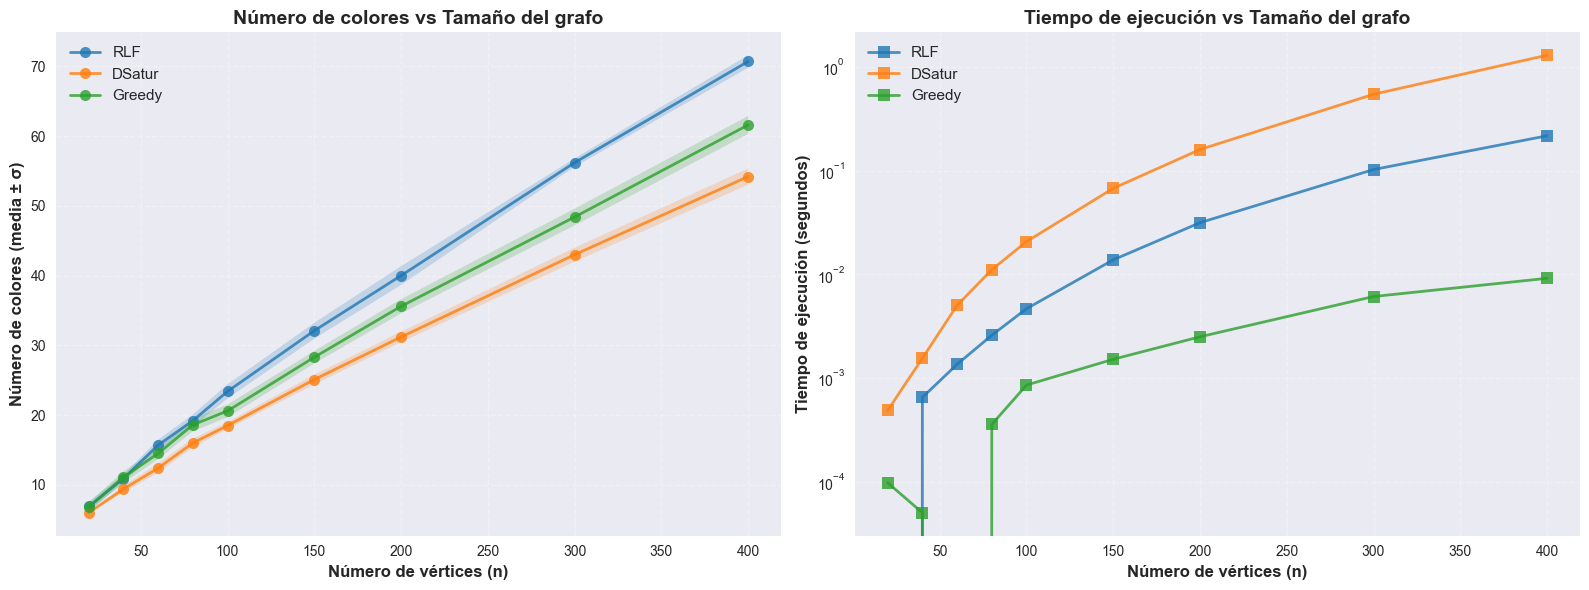

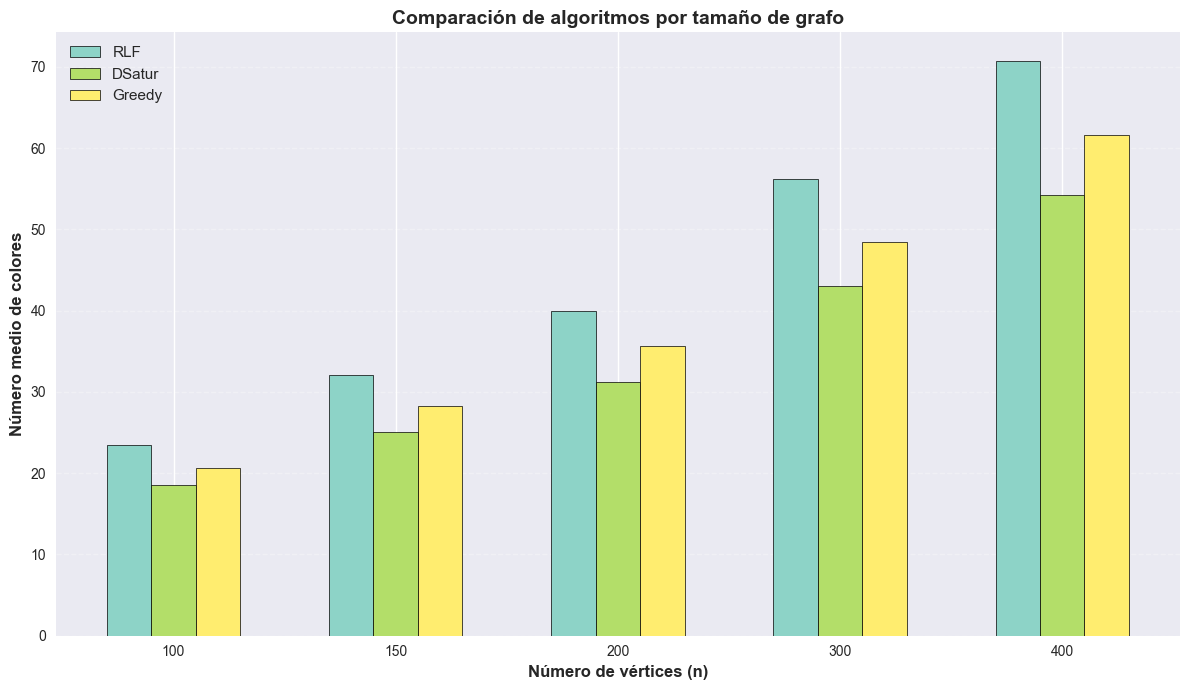

Resumen estadístico por algoritmo:
Algorithm Avg Colors Avg Time (s)  Max n tested
      RLF      30.57       0.0415           400
   DSatur      23.98       0.2336           400
   Greedy      27.28       0.0023           400



In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configurar estilo de las gráficas
plt.style.use('seaborn-v0_8')
sns.set_palette("tab10")

# Crear figura con dos subgráficas
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ---------------------------
# GRÁFICA 1: Número de colores (media ± desviación estándar)
# ---------------------------
ax1 = axes[0]

for algo_name in algorithms.keys():
    # Filtrar datos para este algoritmo
    algo_data = df_results[df_results['Algorithm'] == algo_name]
    
    # Ordenar por n
    algo_data = algo_data.sort_values('n')
    
    # Extraer valores
    n_vals = algo_data['n']
    mean_colors = algo_data['Mean Colors']
    std_colors = algo_data['Std Colors']
    
    # Graficar línea con marcadores
    ax1.plot(n_vals, mean_colors, marker='o', linewidth=2, markersize=8, 
             label=f'{algo_name}', alpha=0.8)
    
    # Añadir área de desviación estándar
    ax1.fill_between(n_vals, 
                     mean_colors - std_colors, 
                     mean_colors + std_colors, 
                     alpha=0.2)

ax1.set_xlabel('Número de vértices (n)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Número de colores (media ± σ)', fontsize=12, fontweight='bold')
ax1.set_title('Número de colores vs Tamaño del grafo', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.legend(loc='best', fontsize=11)
ax1.tick_params(axis='both', which='major', labelsize=10)

# ---------------------------
# GRÁFICA 2: Tiempo de ejecución
# ---------------------------
ax2 = axes[1]

for algo_name in algorithms.keys():
    # Filtrar datos para este algoritmo
    algo_data = df_results[df_results['Algorithm'] == algo_name]
    
    # Ordenar por n
    algo_data = algo_data.sort_values('n')
    
    # Extraer valores
    n_vals = algo_data['n']
    mean_time = algo_data['Mean Time']
    
    # Graficar línea con marcadores (escala logarítmica para tiempos)
    ax2.plot(n_vals, mean_time, marker='s', linewidth=2, markersize=8, 
             label=f'{algo_name}', alpha=0.8)

ax2.set_xlabel('Número de vértices (n)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Tiempo de ejecución (segundos)', fontsize=12, fontweight='bold')
ax2.set_title('Tiempo de ejecución vs Tamaño del grafo', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.legend(loc='best', fontsize=11)
ax2.set_yscale('log')  # Escala logarítmica para mejor visualización de diferencias
ax2.tick_params(axis='both', which='major', labelsize=10)

# Ajustar layout
plt.tight_layout()
plt.show()

# ---------------------------
# GRÁFICA ADICIONAL: Comparación por algoritmo (opcional)
# ---------------------------
fig2, ax3 = plt.subplots(figsize=(12, 7))

# Crear gráfico de barras agrupadas para comparar algoritmos para cada n
n_to_show = [100,150,200,300,400]  # Seleccionar algunos valores de n para claridad
bar_width = 0.2
x_indices = np.arange(len(n_to_show))

algorithms_list = list(algorithms.keys())
colors_plot = plt.cm.Set3(np.linspace(0, 1, len(algorithms_list)))

for idx, algo_name in enumerate(algorithms_list):
    algo_data = df_results[df_results['Algorithm'] == algo_name]
    algo_data = algo_data[algo_data['n'].isin(n_to_show)]
    
    # Ordenar según n_to_show
    algo_data = algo_data.sort_values('n')
    mean_colors = algo_data['Mean Colors'].values
    
    # Asegurar que tenemos datos para todos los n seleccionados
    if len(mean_colors) == len(n_to_show):
        ax3.bar(x_indices + idx * bar_width, mean_colors, bar_width,
                label=algo_name, color=colors_plot[idx], edgecolor='black', linewidth=0.5)

ax3.set_xlabel('Número de vértices (n)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Número medio de colores', fontsize=12, fontweight='bold')
ax3.set_title('Comparación de algoritmos por tamaño de grafo', fontsize=14, fontweight='bold')
ax3.set_xticks(x_indices + bar_width * (len(algorithms_list) - 1) / 2)
ax3.set_xticklabels([str(n) for n in n_to_show])
ax3.legend(loc='upper left', fontsize=11)
ax3.grid(True, alpha=0.3, axis='y', linestyle='--')

plt.tight_layout()
plt.show()

# ---------------------------
# Tabla resumen adicional
# ---------------------------
print("Resumen estadístico por algoritmo:")
print("="*60)

# Crear tabla resumen
summary_stats = []
for algo_name in algorithms.keys():
    algo_data = df_results[df_results['Algorithm'] == algo_name]
    
    # Calcular promedios generales
    avg_colors = algo_data['Mean Colors'].mean()
    avg_time = algo_data['Mean Time'].mean()
    max_n_tested = algo_data['n'].max()
    
    summary_stats.append({
        'Algorithm': algo_name,
        'Avg Colors': f"{avg_colors:.2f}",
        'Avg Time (s)': f"{avg_time:.4f}",
        'Max n tested': max_n_tested
    })

# Mostrar tabla resumen
import pandas as pd
summary_df = pd.DataFrame(summary_stats)
print(summary_df.to_string(index=False))
print("\n" + "="*60)